In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import arviz as az
import stan

import nest_asyncio
nest_asyncio.apply()

# Estimating Drift-Diffusion Model

In this notebook, we estimate the parameter of a drift-diffusion model (DDM) based upon empirical data of a response-time experiment, with two types of task difficulties: easy (small information space for the task) and difficult (large information space for the task). The goal of this model is to determine which condition category (1 or 2) corresponds to which test conditions.

In DDM, the amount of information being processed (information uptake) is best manifested through drift rate $v$ as evidence. Therefore, the model would estimate $v$.

In [42]:
# Load the data
data = pd.read_csv("./data/sample_response_time.csv", delimiter=";")
data.head()

,rt,choice,condition
0,0.477,1.0,1.0
1,0.600,1.0,1.0
2,0.500,0.0,1.0
3,0.416,1.0,1.0
4,0.435,1.0,1.0


/tmp/ipykernel_313456/3604221796.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rt1 = rts[data['condition'] == 1.0]
/tmp/ipykernel_313456/3604221796.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rt2 = rts[data['condition'] == 2.0]


<Axes: xlabel='rt', ylabel='Count'>

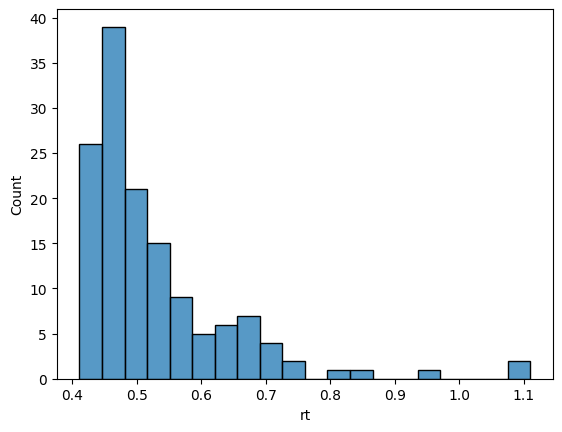

In [26]:
# Inspecting the rt data by condition
rts = data[data['choice'] == 1.0]
rt1 = rts[data['condition'] == 1.0]
rt2 = rts[data['condition'] == 2.0] 

sns.histplot(rt1['rt'], bins=20)

In [47]:
# Load the model
ddm = open("./models/diffusion_model.stan", "r").read()

In [48]:
print(ddm)

data {
    int<lower=1> N;
    array[N] real<lower=0> y;
    array[N] int<lower=1, upper=2> condition;
    array[N] int<lower=0, upper=1> choice;
}

parameters {
    real<lower=0> v;
    real<lower=0> a;
    real<lower=0, upper=1> beta;
    real<lower=0> tau;
}

model {
    // Priors
    // Picking bounded and informative priors
    a ~ gamma(3, 1);
    beta ~ beta(2, 2);
    tau ~ gamma(2, 1);
    v ~ gamma(3, 1);


    // Likelihood
    for (n in 1:N) {
        // Condition 1
        if (condition[n] == 1) {
            if (choice[n] == 1) {
                // Your code here
                y[n] ~ wiener(a, tau, beta, v);
            }
            else {
                // Your code here
                y[n] ~ wiener(a, tau, 1 - beta, -v);
            }
        }
        // Condition 2
        if (condition[n] == 2) {
            if (choice[n] == 1) {
                // Your code here
                y[n] ~ wiener(a, tau, beta, v);
            }
            else {
                // 

In [49]:
d = data.copy().to_numpy()

N = d.shape[0]
y = d[:, 0]
choice = d[:, 1].astype(int)
condition = d[:, 2].astype(int)


# Prepare data in Stan friendly format
data_dict = {
    'N': N,
    'y': y, 
    'choice': choice,
    'condition': condition
}

# Compile model
model = stan.build(ddm, data=data_dict)

Building...



Building: 23.1s, done.

In [50]:
# Posterior inference using MCMC
fit = model.sample(num_chains=4, num_warmup=1000, num_samples=2500)

Sampling:   0%
Sampling:   0% (1/14000)
Sampling:   0% (2/14000)
Sampling:   0% (3/14000)
Sampling:   0% (4/14000)
Sampling:   1% (103/14000)
Sampling:   1% (202/14000)
Sampling:   2% (301/14000)
Sampling:   3% (401/14000)
Sampling:   4% (500/14000)
Sampling:   4% (600/14000)
Sampling:   5% (700/14000)
Sampling:   6% (800/14000)
Sampling:   6% (900/14000)
Sampling:   7% (1000/14000)
Sampling:   8% (1100/14000)
Sampling:   9% (1200/14000)
Sampling:   9% (1300/14000)
Sampling:  10% (1400/14000)
Sampling:  11% (1500/14000)
Sampling:  11% (1600/14000)
Sampling:  12% (1700/14000)
Sampling:  13% (1800/14000)
Sampling:  14% (1900/14000)
Sampling:  14% (2000/14000)
Sampling:  15% (2100/14000)
Sampling:  16% (2200/14000)
Sampling:  16% (2300/14000)
Sampling:  17% (2400/14000)
Sampling:  18% (2500/14000)
Sampling:  19% (2600/14000)
Sampling:  19% (2700/14000)
Sampling:  20% (2800/14000)
Sampling:  21% (2900/14000)
Sampling:  21% (3000/14000)
Sampling:  22% (3100/14000)
Sampling:  23% (3200/14000

In [51]:
df = fit.to_frame()

In [52]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,1.254,0.181,0.923,1.603,0.002,0.002,5805.0,5802.0,1.0
a,0.817,0.023,0.775,0.862,0.000,0.000,6912.0,6629.0,1.0
beta,0.529,0.021,0.490,0.569,0.000,0.000,5533.0,6222.0,1.0
tau,0.398,0.003,0.394,0.403,0.000,0.000,6352.0,6477.0,1.0


/home/geraldwong/.local/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


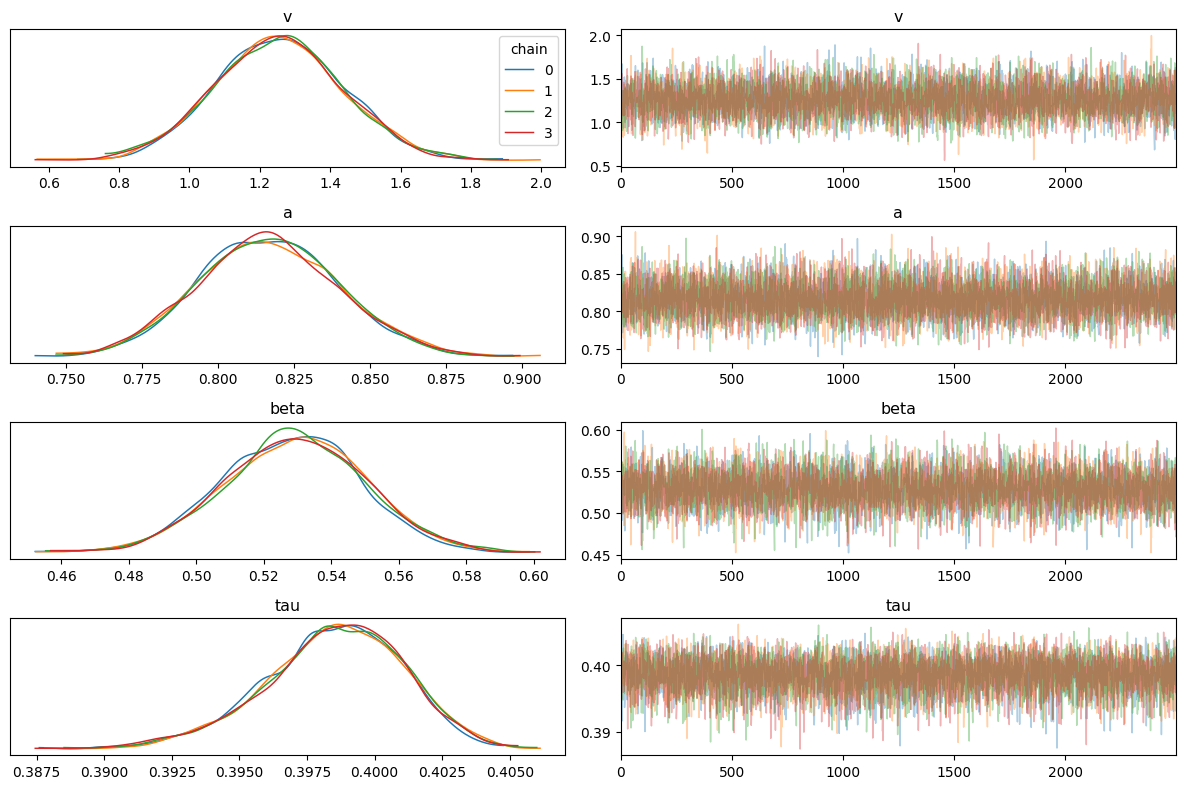

In [53]:
# Traceplots 
f = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()

array([<Axes: title={'center': 'v'}>, <Axes: title={'center': 'a'}>,
       <Axes: title={'center': 'beta'}>, <Axes: title={'center': 'tau'}>],
      dtype=object)

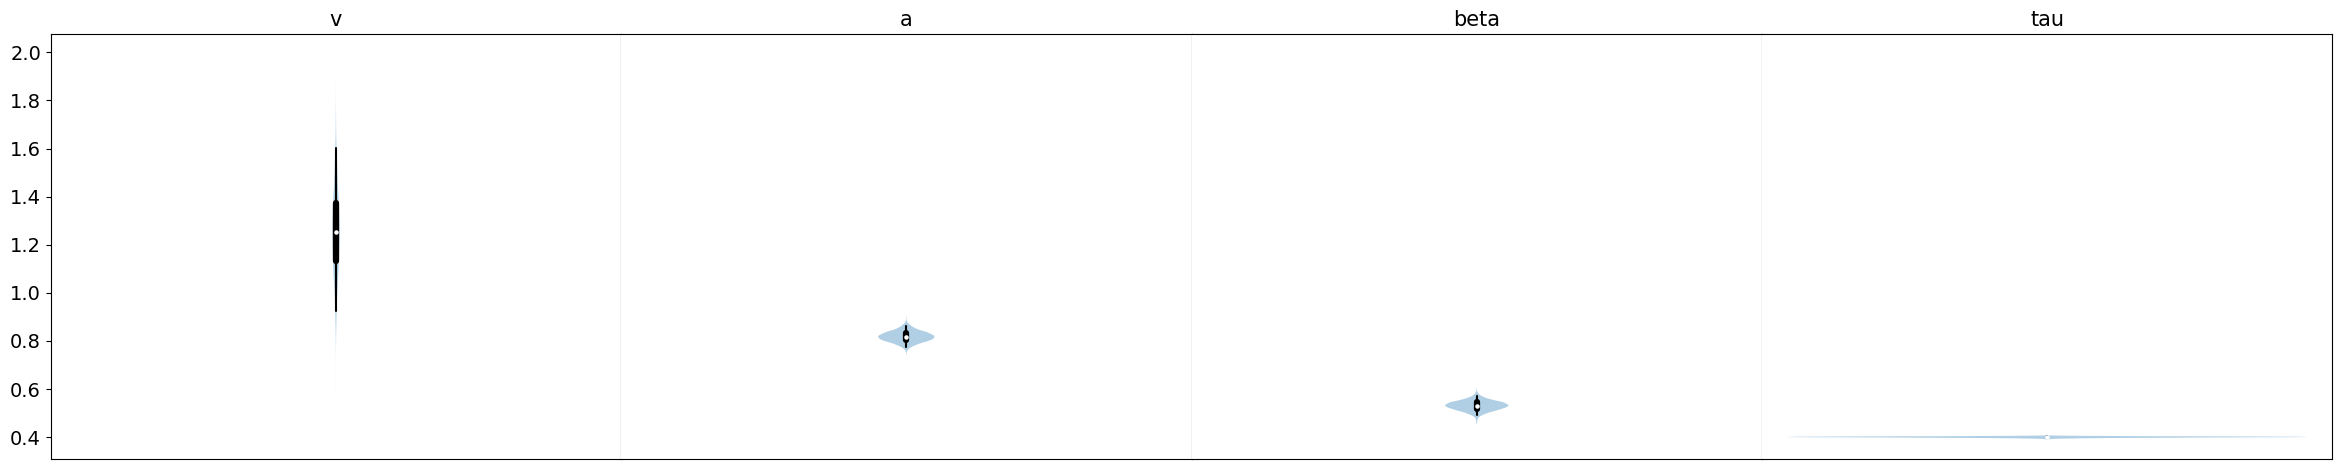

In [55]:
# Inspect diagnostics and create custom functions
var_names = ['v', 'a', 'beta', 'tau']

az.plot_violin(fit, var_names=var_names)

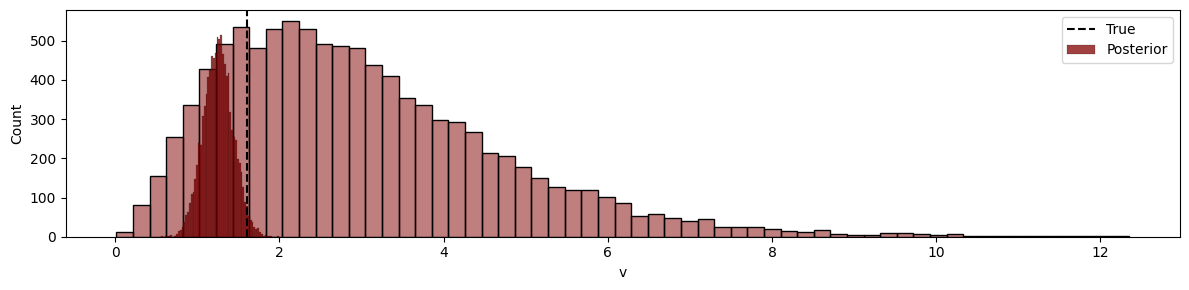

In [56]:
f, ax = plt.subplots(1, 1, figsize=(12, 3))
sns.histplot(np.random.gamma(3, 1, size=10000), color='maroon', ax=ax, alpha=0.5)
sns.histplot(df.v, color='maroon', ax=ax, label='Posterior')
ax.axvline(1.6, color='black', linestyle='--', label='True')
ax.legend()
f.tight_layout()